In [1]:
! pip3 install --upgrade emcee corner pytorch-lightning tqdm nflows scipy zuko


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner
import zuko

# Simulation-based (likelihood-free) inference
Originally by **Siddharth Mishra-Sharma**.
Updated by **Jessie Micallef** ([jessiem@mit.edu](mailto:jessiem@mit.edu))

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jessimic//sbi-tutorial-iaifi/blob/main/tutorial.ipynb)

## 1. Introduction

Simulation-based inference (SBI) is a powerful class of methods for performing inference in settings where the likelihood is computationally intractible or challenging, but simulations can be realized via forward modeling. 

In this lecture we will
- Introduce the concept of an implicit likelihood, and how to leverage it to perform inference;
- Build up two common modern _neural_ SBI techniques: neural likelihood-ratio estimation (NRE) and neural posterior estimation (NPE);
- Introduce the concept of statistical coverage testing and calibration.

As examples, we will look at a simple Gaussian-signal-on-power-law-background ("bump hunt"), where the likelihood is tractable, and a more complicated example of inferring a distribution of point sources, where the likelihood is computationally difficult. We will emphasize what it means for a likelihood to be computationally challenging and where the advantages of SBI come in.

<img src=./assets/likelihood.png alt= “” width=800>
<img src=./assets/sbi.png alt= “” width=800>


# 1.1 Simple bump-on-power-law example

As an initial example, we'll look at a singal and background example. Consider a Gaussian signal ($x_s$), which we can parameterized by some [amplitude ($A_s$), mean location ($\mu_s$), standard deviation ($\sigma_s$)]. This signal will be on top of the background ($x_b$), represented by a power law parameterized as [amplitude ($A_b$), power-law exponent ($n_b$)].
$$x_s = A_s\,\exp^{-(y - \mu_s)^2 / 2\sigma_s^2}$$
$$ x_b = A_b\,y^{n_b}$$
$$x \sim \mathrm{Pois}(x_b + x_s)$$

Let's reproduce one of the most popular examples in particle physics, the mass plot for the higgs boson:

<img src=./assets/higgs_mass_plot_cms.jpg alt= “” width=700>

Text(0.5, 1.0, 'Higgs boson decaying into a pair of photons')

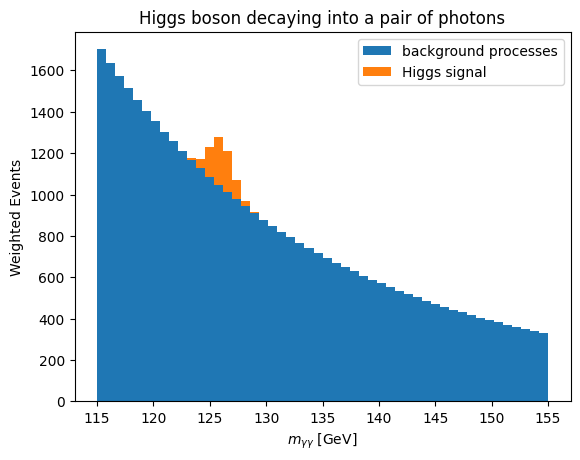

In [3]:
mass_sample = np.linspace(115, 155, 400)  # Mass range in GeV

# Power-law background
exp_b = -5.6
amp_b = 7.5e13
y_b_sample = amp_b * (mass_sample ** exp_b)  

# Gaussian signal 
amp_s=30
mu_s=126 #Measured higgs mass
std_s = 1
y_s_sample = amp_s * np.exp(-((mass_sample - mu_s) ** 2) / (2 * std_s ** 2)) 

#Make stacked histogram to see distribution that you would be pulling from
plt.hist([mass_sample, mass_sample], bins=50, weights=[y_b_sample, y_s_sample], label=['background processes', 'Higgs signal'], stacked=True)

plt.legend()
plt.xlabel(r'$m_{\gamma \gamma}$ [GeV]')
plt.ylabel("Weighted Events")
plt.title("Higgs boson decaying into a pair of photons")


### Now we've visualized this, we will make a single forward model that contains both signal + background

In [4]:
#Make signal + background into one "forward model"
def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top 
    of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

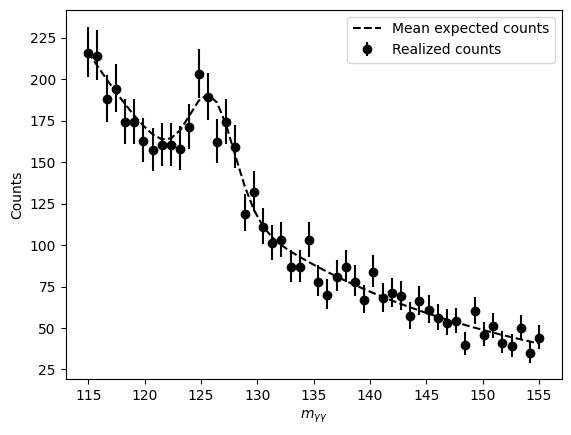

In [50]:
y = np.linspace(115, 155, 50)  # Dependent variable

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=60, mu_s=126, std_s=2,  # Signal params -- BUMP UP amplitute and std for ease
                    amp_b=7.5e13, exp_b=-5.6)  # Background params

# Realized counts
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

# Plot
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")

plt.xlabel(r"$m_{\gamma\gamma}$")
plt.ylabel("Counts")

plt.legend();

# plt.savefig("assets/x1.pdf")

## 1.2 The explicit likelihood

In this case, we can write down a log-likelihood as a Poisson over the mean returned by the forward model.

In [6]:
def log_like(theta, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) 
    on top of a power-law background (amp_b, exp_b).
    """
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

Let's focus on just 2 parameters for simplicity, the signal amplitude and mean location. The likelihood in this case is:

In [7]:
def log_like_sig(params, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 1, 7.5e13, -5.6
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like_sig([60, 126], y, x)

-204.22751120804847

### Get a maximum-liklelihood estimate:

In [25]:
# Initial guess for the parameters
initial_guess = [100., 135.]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (100, 150))}

# Perform the optimization using basinhopping
opt = basinhopping(lambda thetas: -log_like_sig(thetas, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt.x, (60, 126)))


MLE parameters: [ 79.40918964 126.46353117]; true parameters: (60, 126)


### And approximate posterior using `emcee`:

In [26]:
def log_prior(thetas):
    """ Log-prior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 100 < mu_s < 150: #0 < mu_s < 2: 
        return 0
    else:
        return -np.inf
    
def log_post(thetas, y, x):
    """ Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x)
    

In [39]:
# Sampling with `emcee`
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e1 * np.random.randn(nwalkers, ndim) #starting position for the walkers with slight variation
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:09<00:00, 1007.66it/s]


In [40]:
pos

array([[ 78.86152112, 131.2968942 ],
       [ 53.5636073 , 107.68069495],
       [ 84.52588742, 132.39174136],
       [ 75.36836209, 140.58622924],
       [ 87.73122334, 119.83564776],
       [ 87.68011154, 120.04934949],
       [ 68.67656338, 118.58962782],
       [ 64.84062855, 114.75857927],
       [ 73.05107151, 131.10124429],
       [ 63.55776163, 111.04539003],
       [ 64.24251972, 121.82347235],
       [ 76.83298488, 129.85947081],
       [ 82.3251027 , 117.39854968],
       [ 86.84655892, 124.94791079],
       [ 64.43161193, 114.93846564],
       [ 86.90948669, 125.54411934],
       [ 82.43763101, 126.21082236],
       [ 88.90302596, 146.56424746],
       [ 77.78094216, 141.0243717 ],
       [ 78.04557032, 132.98473229],
       [ 76.83331168, 123.82778212],
       [ 88.62784581, 117.02533027],
       [ 68.55432092, 105.8363667 ],
       [ 81.36528351, 145.67925398],
       [ 67.18786532, 129.21465714],
       [ 75.9696249 , 131.9453341 ],
       [ 86.21486052, 120.43273122],
 

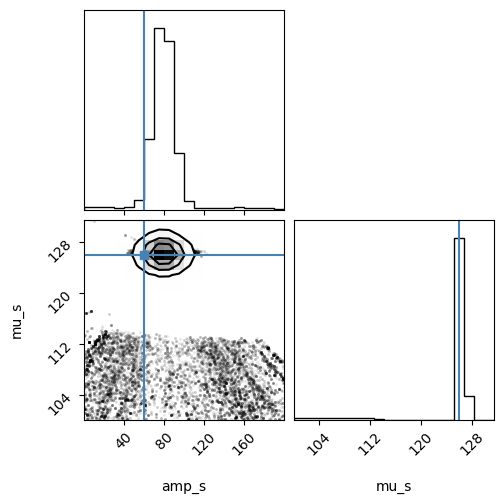

In [43]:
# Plot posterior samples
flat_samples = sampler.get_chain(discard=5000, flat=True) #"Burn in" or discrading the first X steps is common practice for MCMC
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[60, 126], smooth=1.);

### Exercise: How does this change if you alter the number of walkers, sampling, burn-in, etc.? What if you use another MC method (https://chi-feng.github.io/mcmc-demo/)?

Hint: You will need to use a differnt package instead of emcee. Some options: pymc, pyhmc, tensorflow, pytorch

In [ ]:
# Sampling with `pyhmc`


## 1.3 The implicit likelihood

Now we will do inference without relying on the explicit likelihood evaluation. The key realization is that samples from the forward model implicitly encode the likelihood; when we are simulating data points $x$ for different parameter points $\theta$, we are drawing samples from the likelihood:
$$x\sim p(x\mid\theta)$$
which is where the _implicit_ aspect comes from. Let's write down a bump simulator:

#### Let's write a simulator for the bump example:
<a id="bump_sim"></a>

In [66]:
def bump_simulator(thetas, y):
    """ Simulate samples from the bump forward model given theta = (amp_s, mu_s) and dependent variable points y.
    """
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 1, 7.5e13, -5.6
    x_mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    settings = {"amp_s": amp_s, "mu_s": mu_s, "std_s": std_s, "amp_b": amp_b, "exp_b": exp_b}
    return x, settings

# Test it out
y = np.linspace(100, 150, 100)   # INCREASE SAMPLING comapred to before (now 100 instead of 50)

x_simulated, setting_vals = bump_simulator([100, 126], y) #STRONGER SIGNAL --> amp_s = 100, mu_s = 126
print(x_simulated)

[505 484 449 395 463 444 388 385 399 350 374 341 334 323 300 304 279 303
 314 291 278 246 261 236 234 254 254 233 228 231 219 197 211 194 190 186
 190 191 190 184 155 173 149 144 160 165 139 147 130 175 217 227 221 184
 170 178 127 100 107 100  99  99 104 115 110 107 102  97  97  89  84  97
  81  73  87  99  72  76  80  73  75  73  77  66  69  60  69  84  50  53
  54  52  40  44  43  57  51  50  45  48]


### **Exercise:** Run the bump simulator multiple times. Notice that each time you run the cell above, the distribution changes. What makes the signal bump larger? What settings for the background makes your signal disappear? What moves the signal bump?

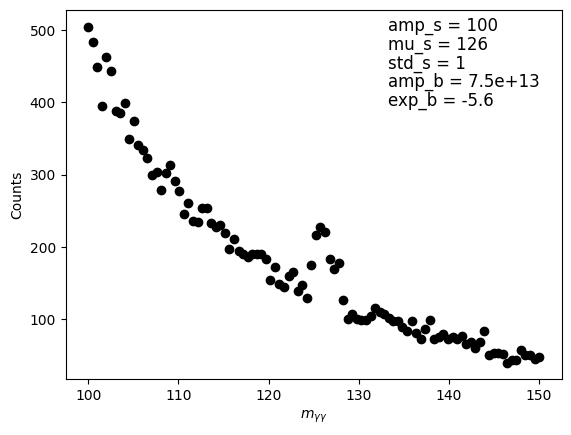

In [67]:
#Plot bump simulator
plt.plot(y,x_simulated,'ko')
plt.xlabel(r"$m_{\gamma\gamma}$")
plt.ylabel("Counts")
for i, (name, value) in enumerate(setting_vals.items()):
    if value > 200:
            plt.text(0.65, 0.98 - i * 0.05, f"{name} = {value:.1e}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    else:
        plt.text(0.65, 0.98 - i * 0.05, f"{name} = {value}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

## 1.4 Approximate Bayesian Computation (ABC)

We will not be focusing on ABC, but the concept can help to understand as a stepping stone before we start to use neural methods in place of Bayesian Computation. Brief overview:

<img src=./assets/abc.png alt= “” width=800>


The idea behind ABC is to simulate samples from the forward model (with the parameters $\theta$ drawn from a prior) and compare it to the dataset of interest $x$. If the data and realized samples are close enough to each other according to some criterion (such as Mean Squared Error), we keep the parameter points.

Downsides of vanilla ABC:
- How to summarize the data? Curse of dimensionality / loss of information.
- How to compare with data? Likelihood may not be available.
- Choice of acceptance threshold: Precision/efficiency tradeoff.
- Need to re-run pipeline for new data or new prior.

# 2. Neural likelihood-ratio estimation (NRE)

Now we will still be using the [bump simulator](#bump_sim) (Section 1.3), but now feed this into a neural network and explore how to use NRE to evaluate the likelihood ratio.

<img src=./assets/nre.png alt= “” width=1000>

For numerical stability, the alternate hypothesis $\theta_0$ can be assumed to be one where $x$ and $\theta$ are not correlated, i.e., drawn from the individual marginal distributions $\{x, \theta\} \sim p(x)\,p(\theta)$. Then the alternate has support over the entire parameter space, instead of being a single hypothesis $\theta_0$.

In this case, we get the likelihood-to-evidence ratio,

$$\hat r(x, \theta) = \frac{s(x, \theta)}{1 - s(x, \theta)} = \frac{p(x,\theta)}{p(x)p(\theta)} = \frac{p(x\mid\theta)}{p(x)}$$

$\hat r(x, \theta)$ can be shown to be the classifier logit, i.e. the output before softmaxxing into the decision function with range between 0 and 1.

#### Start by creating some training data with [bump simulator](#bump_sim):

In [68]:
n_train = 50_000

# Simulate training data
theta_samples = np.random.uniform(low=[0, 100], high=[200, 150], size=(n_train, 2))  # Parameter proposal, 0 < amp_s < 200, 100 < mu_s < 150
y = np.linspace(100, 150, 100)
x_samples = np.array([bump_simulator(theta, y)[0] for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

100%|██████████| 50000/50000 [00:00<00:00, 57769.95it/s]


In [69]:
print(theta_samples.shape, x_samples.shape)

torch.Size([50000, 2]) torch.Size([50000, 100])


## 2.1. As our parameterized classifier, we will use a simple MLP.

In [70]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

Create a neural ratio estimator class, with a corresponding loss function. The loss is a simple [binary cross-entropy loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) that discriminates between samples from the joint distribution $\{x, \theta\} \sim p(x\mid\theta)$ and those from a product of marginals $\{x, \theta\} \sim p(x)\,p(\theta)$. Samples from the latter are obtained by shuffling joint samples from within a batch.

The binary cross-entropy loss is used as the classifier loss to distinguish samples from the joint and marginals,
$$\mathcal L = - \sum_i y_i \log(p_i)$$
where $y_i$ are the true labels and $p_i$ the softmaxxed probabilities.

In [71]:
class NeuralRatioEstimator(pl.LightningModule):
    """ Simple neural likelihood-to-evidence ratio estimator, using an MLP as a parameterized classifier.
    """
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)
    
    def loss(self, x, theta):

        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device) 
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        return nn.BCELoss(reduction='none')(probs, labels)


    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [73]:
# Evaluate loss; initially it should be around -log(0.5) = 0.693
nre = NeuralRatioEstimator(x_dim=len(y), theta_dim=2)
initial_loss_array = nre.loss(x_samples[:64], theta_samples[:64])
print(initial_loss_array)

tensor([0.7246, 0.6627, 0.7243, 0.6628, 0.7223, 0.6648, 0.7252, 0.6614, 0.7252,
        0.6621, 0.7243, 0.6626, 0.7254, 0.6618, 0.7241, 0.6632, 0.7246, 0.6629,
        0.7243, 0.6629, 0.7239, 0.6632, 0.7237, 0.6635, 0.7231, 0.6641, 0.7243,
        0.6632, 0.7231, 0.6640, 0.7243, 0.6633, 0.7222, 0.6647, 0.7244, 0.6629,
        0.7220, 0.6649, 0.7230, 0.6643, 0.7247, 0.6628, 0.7249, 0.6623, 0.7234,
        0.6639, 0.7238, 0.6636, 0.7237, 0.6636, 0.7244, 0.6625, 0.7245, 0.6627,
        0.7246, 0.6624, 0.7254, 0.6617, 0.7243, 0.6633, 0.7238, 0.6633, 0.7237,
        0.6636, 0.7248, 0.6626, 0.7223, 0.6646, 0.7233, 0.6638, 0.7235, 0.6637,
        0.7248, 0.6627, 0.7264, 0.6609, 0.7245, 0.6629, 0.7235, 0.6638, 0.7249,
        0.6622, 0.7247, 0.6627, 0.7244, 0.6630, 0.7224, 0.6650, 0.7241, 0.6632,
        0.7243, 0.6629, 0.7249, 0.6624, 0.7244, 0.6627, 0.7233, 0.6639, 0.7255,
        0.6619, 0.7250, 0.6622, 0.7243, 0.6632, 0.7239, 0.6633, 0.7255, 0.6618,
        0.7239, 0.6633, 0.7243, 0.6628, 

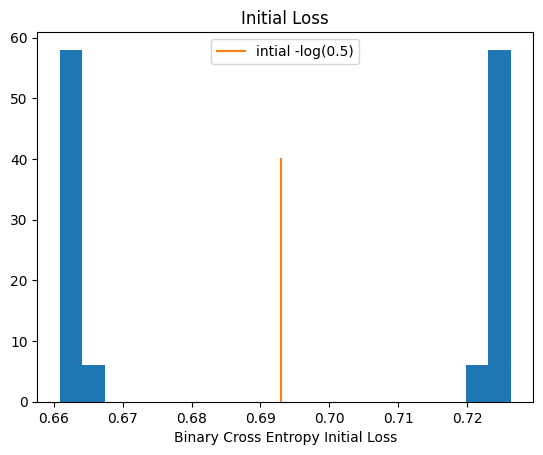

In [74]:
plt.hist(initial_loss_array.detach().numpy(),bins=20)
plt.plot([0.693,0.693],[0,40],label="intial -log(0.5)")
plt.xlabel("Binary Cross Entropy Initial Loss")
plt.title("Initial Loss")
plt.legend()

In [75]:
#Run dataloader
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [76]:
#Train
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 79.4 K | train
--------------------------------------------------
79.4 K    Trainable params
0         Non-trainable params
79.4 K    Total params
0.317     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 352/352 [00:07<00:00, 47.79it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 352/352 [00:07<00:00, 47.71it/s, v_num=1]


The classifier logits are now an estimator for the likelihood ratio. We can write down a log-likelihood function and use it to sample from the corresponding posterior distribution, just like before.

In [77]:
def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """
        
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze()

theta_test = np.array([90, 119]) #INSERT A POINT TO TEST (RECALL TRUTH is amp_s = 100, mu_s = 126)
x_test = bump_simulator(theta_test, y)[0]

log_like(theta_test, x_test)

tensor(3.4146, grad_fn=<SqueezeBackward0>)

In [78]:
def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x).detach().numpy()

Sample with `emcee`:

In [80]:
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e1 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:30<00:00, 323.92it/s]


#### Plot approximate posterior:

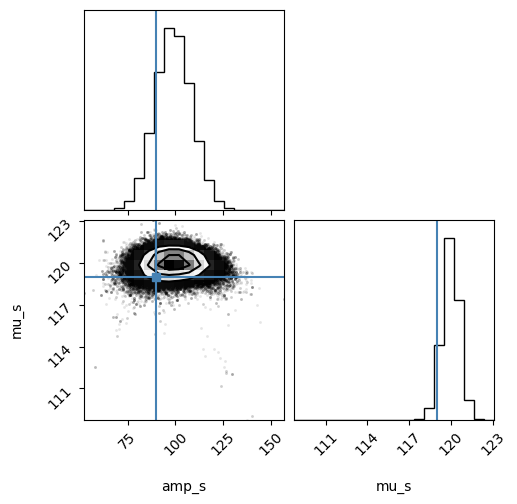

In [82]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[90, 119]);

# 3. Neural posterior estimation (NPE)

<img src=./assets/npe.png alt= “” width=800>

#### Generic Neural Spline Flow in zuko

In [215]:
# Neural spline flow (NSF) with 3 sample features and 5 context features
flow = zuko.flows.NSF(3, 5, transforms=3, hidden_features=[128] * 3)

# Train to maximize the log-likelihood
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for x, c in dataset_train:
    loss = -flow(c).log_prob(x)  # -log p(x | c)
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Sample 64 points x ~ p(x | c*)
x = flow(c_star).sample((64,))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x52 and 8x128)

In [213]:
import zuko

# Define the function to create the flow
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """Instantiate a simple (Masked Autoregressive) normalizing flow using Zuko."""

    base_dist = zuko.distributions.DiagNormal(loc=0,scale=1,ndims=d_in)

    transforms = []
    for _ in range(n_layers):
        transforms.append(zuko.transforms.ReversePermutation(d_in))
        transforms.append(zuko.transforms.MaskedAffineAutoregressiveTransform(d_in, d_hidden, context_dim=d_context))
    
    transform = zuko.transforms.CompositeTransform(transforms)
    
    flow = zuko.flows.Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
context = torch.randn(2, 16)
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=context)
print(samples.shape, log_prob.shape)

ValueError: Expected reinterpreted_batch_ndims <= len(base_distribution.batch_shape), actual 2 vs 0

In [25]:
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 2]) torch.Size([2, 100])


Construct a neural posterior estimator. It uses a normalizing flow as a (conditional) posterior density estimator, and a feature-extraction network that aligns the directions of variations in parameters $\theta$ and data $x$.
$$  \mathcal L = -\log p_\phi(\theta\mid s_\varphi(x))$$
where $\{\phi, \varphi\}$ are the parameters of the normalizing flow and featurizer MLP, respectively.

In [26]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

Instantiate the NPE class and look at the loss:

In [27]:
npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=50, hidden_dim=128, output_dim=16, layers=4))
npe.loss(x_samples[:64], theta_samples[:64])

tensor([3.7843, 3.8738, 3.9518, 4.0794, 3.6791, 3.9817, 4.3857, 4.4798, 4.5228,
        4.7221, 3.6710, 4.4517, 4.2133, 3.9601, 4.4137, 4.6108, 3.9406, 4.7328,
        4.3728, 4.4590, 3.7482, 4.2472, 4.3484, 4.0043, 4.0342, 3.9290, 3.7566,
        4.2563, 4.4851, 4.3799, 4.2393, 3.7989, 4.3761, 4.1313, 3.9437, 4.2510,
        4.7588, 4.3307, 4.2605, 3.9174, 3.6827, 4.3489, 4.4073, 3.8204, 4.1285,
        4.5042, 4.6367, 4.4233, 3.8328, 4.8085, 4.4506, 4.7571, 3.7327, 4.0766,
        4.4962, 4.2689, 4.4157, 4.5896, 4.2844, 4.4578, 3.8447, 4.2823, 4.8359,
        4.1344], grad_fn=<NegBackward0>)

Train using the same data as before:

In [28]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | featurizer | Sequential | 74.6 K
1 | flow       | Flow       | 24.3 K
------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

ERROR: Unexpected segmentation fault encountered in worker.
 

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Get a test data sample, pass it through the feature extractor, and condition the flow density estimator on it. We get posterior samples by drawing from 
$$\theta \sim p_\phi(\theta\mid s_\varphi(x)).$$

In [29]:
theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

In [30]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

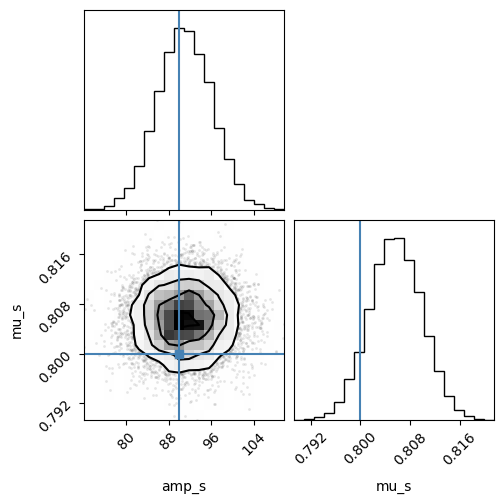

In [31]:
samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()
corner.corner(samples_test, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

# Further reading

- [The frontier of simulation-based inference](https://arxiv.org/abs/1911.01429) (Cranmer, Brehmer, Louppe): Review paper
- [simulation-based-inference.org](http://simulation-based-inference.org/): List of papers and resources
- [awesome-neural-sbi](https://github.com/smsharma/awesome-neural-sbi): List of papers and resources

<img src=./assets/header.png alt= “” width=800>
Credit: Siddharth